# Tree Learning – implementation and application of decision trees

## Introduction

This notebook gives you the opportunity to implement some key components of decision tree learning and run your algorithm on a benchmark dataset. So restrictions will be made to simplify the problem. The notebook concludes by asking you to run the decision tree learning (and tree-based method of "Random Forests") from scikit-learn for comparison.

Make sure you have the Titanic dataset ("```titanic.csv```") in the directory from where you are running the notebook before you start.

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
ds = pd.read_csv('titanic.csv')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Preprocessing 

To simplify things we will focus on the supplied dataset and start by doing some preprocessing, including feature selection, turning categorical data to numeric, and some other stuff. Spend about 10 minutes and go through this if you have any doubts. We start by inspecting the dataset. 

In [7]:
ds.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Do we need all the features ? No.

In [8]:
cols_to_drop = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin',
    'Embarked',
]

df = ds.drop(cols_to_drop, axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


Another simplification will be to treat all attributes as numeric. So we need to convert any that are not.

In [9]:
def convert_sex_to_num(s):
    if s=='male':
        return 0
    elif s=='female':
        return 1
    else:
        return s

df.Sex = df.Sex.map(convert_sex_to_num)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


Let's overview the preprocessed dataset now with some standard commands.

In [10]:
data = df.dropna()
data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373,34.694514
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,15.741700
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200


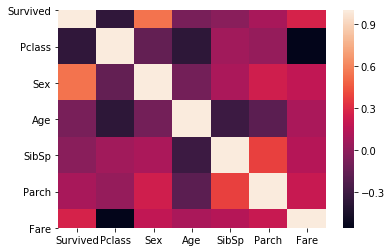

In [11]:
plt.figure()
sns.heatmap(data.corr())

In [19]:
input_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
out_cols = ['Survived']

X = data[input_cols]
y = data[out_cols]

#X.head()
print (X.shape, y.shape)
print (X.columns)

(714, 6) (714, 1)
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


In [13]:
data = data.reset_index(drop=True)

In [14]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
709,0,3,1,39.0,0,5,29.1250
710,0,2,0,27.0,0,0,13.0000
711,1,1,1,19.0,0,0,30.0000
712,1,1,0,26.0,0,0,30.0000


## Functions for your Decision Tree learning algorithm

Now is your chance to go ahead and implement some of the functionality needed for the decision tree learner. Remember that the _class_ variable for which we need to learn a tree is ```Survived```.

In [17]:
x_right = pd.DataFrame([], columns=data.columns)
x_left = pd.DataFrame([], columns=data.columns)
x_right

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare


In [31]:
def divide_data(x_data, fkey, fval):
    x_right = pd.DataFrame([], columns=x_data.columns)
    x_left = pd.DataFrame([], columns=x_data.columns)
    
    for ix in range(x_data.shape[0]):
        # Retrieve the current value for the fkey column lets call it val
        val = x_data.loc[ix, fkey]
        try:
            #TODO
            row = x_data.loc[ix]
        except:
            #TODO
            print('Error')
        
        # Check where the row needs to go
        if val > fval:
            # pass the row to right
            #TODO
            x_right.loc[ix] = row
        else:
            # pass the row to left
            #TODO
            x_left.loc[ix] = row
    # return the divided datasets
    #TODO
    return {'right':x_right, 'left':x_left}

def entropy(col):
    #TODO
    positive = col[col['Survived'] == 1]
    negetive = col[col['Survived'] == 0]
    
    
    
    
# def information_gain(xdata, fkey, fval):
    #TODO
    
dict_data = divide_data(X, 'Sex', 0)


{'right':      Pclass  Sex   Age  SibSp  Parch     Fare
 1       1.0  1.0  38.0    1.0    0.0  71.2833
 2       3.0  1.0  26.0    0.0    0.0   7.9250
 3       1.0  1.0  35.0    1.0    0.0  53.1000
 7       3.0  1.0  27.0    0.0    2.0  11.1333
 8       2.0  1.0  14.0    1.0    0.0  30.0708
 ..      ...  ...   ...    ...    ...      ...
 703     1.0  1.0  56.0    0.0    1.0  83.1583
 704     2.0  1.0  25.0    0.0    1.0  26.0000
 706     3.0  1.0  22.0    0.0    0.0  10.5167
 709     3.0  1.0  39.0    0.0    5.0  29.1250
 711     1.0  1.0  19.0    0.0    0.0  30.0000
 
 [261 rows x 6 columns],
 'left':      Pclass  Sex   Age  SibSp  Parch     Fare
 0       3.0  0.0  22.0    1.0    0.0   7.2500
 4       3.0  0.0  35.0    0.0    0.0   8.0500
 5       1.0  0.0  54.0    0.0    0.0  51.8625
 6       3.0  0.0   2.0    3.0    1.0  21.0750
 11      3.0  0.0  20.0    0.0    0.0   8.0500
 ..      ...  ...   ...    ...    ...      ...
 707     2.0  0.0  28.0    0.0    0.0  10.5000
 708     3.0  0.

In [12]:
#Here X is your data without the Survived column. Run it after you have filled in the missing code above. 
'''
for fx in X.columns:
    print (fx) 
    print (information_gain(data, fx, data[fx].mean()))
'''

'\nfor fx in X.columns:\n    print (fx) \n    print (information_gain(data, fx, data[fx].mean()))\n'

In [34]:
class DecisionTree:
    def __init__(self, depth=0, max_depth=5):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.max_depth = max_depth
        self.depth = depth
        self.target = None
    
    def train(self, X_train):
        
        print (self.depth, '-'*10)
        # Get the best possible feature and division value (gains)
        #TODO
        
        # store the best feature (using min information gain)
        #TODO
        
        # divide the dataset and reset index 
        #TODO
        
        # Check the shapes and depth if it has exceeded max_depth or not in case it has make predictions 
        # TODO
        
        # branch to right
        #TODO
        
        # branch to left
        #TODO
        
        #Make your prediction 
        #TODO
        
        return
    
    def predict(self, test):
        if test[self.fkey] > self.fval:
            pass
            # go right
            #TODO
        else:
            pass
            # go left
            #TODO

## Divide your data: separate Training and Test sets

## Train your own decision tree

In [36]:
'''
dt = DecisionTree()
dt.train(training_data)
'''

'\ndt = DecisionTree()\ndt.train(training_data)\n'

In [37]:
'''
print (dt.fkey, dt.fval)
print (dt.right.fkey, dt.right.fval)
print (dt.left.fkey, dt.left.fval)

print (dt.right.right.fkey, dt.right.right.fval)
print (dt.right.left.fkey, dt.right.left.fval)


print (dt.left.right.fkey, dt.left.right.fval)
print (dt.left.left.fkey, dt.left.left.fval)
'''

'\nprint (dt.fkey, dt.fval)\nprint (dt.right.fkey, dt.right.fval)\nprint (dt.left.fkey, dt.left.fval)\n\nprint (dt.right.right.fkey, dt.right.right.fval)\nprint (dt.right.left.fkey, dt.right.left.fval)\n\n\nprint (dt.left.right.fkey, dt.left.right.fval)\nprint (dt.left.left.fkey, dt.left.left.fval)\n'

Make predictions for the first 10 and see if they are correct.  

In [ ]:
for ix in testing_data.index[:10]:
    print (dt.predict(testing_data.loc[ix]))

In [ ]:
testing_data.head(10)

Now check for the entire test set how many you get correct: aim to get at least 75 percent accuracy !

## Now use SKLEARN: Decision tree and Random Forests